In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from tqdm import tqdm
import math

# Load data
df = pd.read_csv("p1_emg.csv")  # Replace with actual filename


In [2]:
# Label mapping (excluding 'rest')
mapg = {
    "Thumb Extension":0,"index Extension":1,"Middle Extension":2,"Ring Extension":3,
    "Pinky Extension":4,"Thumbs Up":5,"Right Angle":6,"Peace":7,"OK":8,"Horn":9,"Hang Loose":10,
    "Power Grip":11,"Hand Open":12,"Wrist Extension":13,"Wrist Flexion":14,
    "Ulnar deviation":15,"Radial Deviation":16
}

df = df[df['label'] != 'rest']
df['label'] = df['label'].map(mapg)

# Normalize EMG features
features = [col for col in df.columns if 'emg' in col]
# Min-Max Scaling to [0, 1]
min_vals = df[features].min()
max_vals = df[features].max()
df[features] = (df[features] - min_vals) / (max_vals - min_vals + 1e-8)


# Parameters
window_size = 100  # adjust based on your data
features = [col for col in df.columns if 'emg' in col]

# Create clean, non-overlapping windows with consistent labels
X = []
y = []

for i in range(0, len(df) - window_size + 1, window_size):
    window = df.iloc[i:i+window_size]
    label_set = window['label'].unique()
    if len(label_set) == 1:  # Only keep windows with a single label
        X.append(window[features].values.astype(np.float32))
        y.append(label_set[0])

X = np.array(X)
y = np.array(y)

# Dataset
class EMGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)  # shape: (N, window, channels)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].permute(1, 0), self.y[idx]  # shape: (channels, window)

dataset = EMGDataset(X, y)

In [3]:
len(dataset)

2916

In [4]:
# Split data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [5]:

class EMGCNN(nn.Module):
    def __init__(self, num_classes=17, num_channels=8):
        super(EMGCNN, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate output size after convolutions and pooling
        conv_output_size = window_size
        for _ in range(3):  # 3 conv + pool layers
            conv_output_size = conv_output_size // 2  # MaxPool1d halves it

        self.fc1 = nn.Linear(256 * conv_output_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 64, L/2)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 128, L/4)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> (B, 256, L/8)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    


In [6]:
class DeepEMGCNN(nn.Module):
    def __init__(self, num_classes=17, num_channels=8, window_size=256):
        super(DeepEMGCNN, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)
            )

        self.layer1 = conv_block(num_channels, 64)
        self.layer2 = conv_block(64, 128)
        self.layer3 = conv_block(128, 256)
        self.layer4 = conv_block(256, 512)

        # Compute final flattened size
        conv_output_size = window_size
        for _ in range(4):
            conv_output_size //= 2  # MaxPool1d halves the length

        self.fc1 = nn.Linear(3072, 256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)  # (B, 64, L/2)
        x = self.layer2(x)  # (B, 128, L/4)
        x = self.layer3(x)  # (B, 256, L/8)
        x = self.layer4(x)  # (B, 512, L/16)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [7]:
# Train setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EMGCNN(num_classes=len(mapg)).to(device)
criterion = nn.CrossEntropyLoss()


In [8]:
len(mapg)

17

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=17).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(torch.argmax(outputs, dim=1), targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [11]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=17).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(torch.argmax(outputs, dim=1), targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [12]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [16]:
num_epochs = 100

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 criterion, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     val_loader,
                                     criterion)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Best Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 73/73 [00:00<00:00, 116.53batch/s, accuracy=90.6, loss=0.395]


Valid: Loss = 1.686, Acc = 0.5325



Epoch 1: 100%|██████████| 73/73 [00:00<00:00, 166.63batch/s, accuracy=91, loss=0.393]  


Valid: Loss = 1.479, Acc = 0.5753



Epoch 2: 100%|██████████| 73/73 [00:00<00:00, 163.72batch/s, accuracy=90.8, loss=0.39] 


Valid: Loss = 1.589, Acc = 0.5462



Epoch 3: 100%|██████████| 73/73 [00:00<00:00, 164.92batch/s, accuracy=91.3, loss=0.394]


Valid: Loss = 1.462, Acc = 0.5685



Epoch 4: 100%|██████████| 73/73 [00:00<00:00, 156.00batch/s, accuracy=90.5, loss=0.405]


Valid: Loss = 1.307, Acc = 0.6147



Epoch 5: 100%|██████████| 73/73 [00:00<00:00, 162.26batch/s, accuracy=91.2, loss=0.378]


Valid: Loss = 1.126, Acc = 0.649



Epoch 6: 100%|██████████| 73/73 [00:00<00:00, 157.02batch/s, accuracy=90.6, loss=0.391]


Valid: Loss = 1.38, Acc = 0.5651



Epoch 7: 100%|██████████| 73/73 [00:00<00:00, 159.51batch/s, accuracy=91, loss=0.383]  


Valid: Loss = 1.247, Acc = 0.6182



Epoch 8: 100%|██████████| 73/73 [00:00<00:00, 160.56batch/s, accuracy=91.3, loss=0.375]


Valid: Loss = 1.146, Acc = 0.649



Epoch 9: 100%|██████████| 73/73 [00:00<00:00, 158.47batch/s, accuracy=91.2, loss=0.377]


Valid: Loss = 1.179, Acc = 0.6627



Epoch 10: 100%|██████████| 73/73 [00:00<00:00, 158.03batch/s, accuracy=92.2, loss=0.367]


Valid: Loss = 1.249, Acc = 0.6079



Epoch 11: 100%|██████████| 73/73 [00:00<00:00, 155.49batch/s, accuracy=91.4, loss=0.381]


Valid: Loss = 1.741, Acc = 0.5068



Epoch 12: 100%|██████████| 73/73 [00:00<00:00, 161.04batch/s, accuracy=91.8, loss=0.364]


Valid: Loss = 1.509, Acc = 0.5736



Epoch 13: 100%|██████████| 73/73 [00:00<00:00, 164.68batch/s, accuracy=91.4, loss=0.372]


Valid: Loss = 1.49, Acc = 0.5753



Epoch 14: 100%|██████████| 73/73 [00:00<00:00, 165.54batch/s, accuracy=91.9, loss=0.356]


Valid: Loss = 1.272, Acc = 0.6438



Epoch 15: 100%|██████████| 73/73 [00:00<00:00, 168.87batch/s, accuracy=92.4, loss=0.344]


Valid: Loss = 2.345, Acc = 0.4435



Epoch 16: 100%|██████████| 73/73 [00:00<00:00, 163.63batch/s, accuracy=92.8, loss=0.342]


Valid: Loss = 1.383, Acc = 0.5873



Epoch 17: 100%|██████████| 73/73 [00:00<00:00, 165.38batch/s, accuracy=92.3, loss=0.351]


Valid: Loss = 1.743, Acc = 0.4983



Epoch 18: 100%|██████████| 73/73 [00:00<00:00, 166.48batch/s, accuracy=91.6, loss=0.364]


Valid: Loss = 1.124, Acc = 0.6644



Epoch 19: 100%|██████████| 73/73 [00:00<00:00, 160.08batch/s, accuracy=92.2, loss=0.334]


Valid: Loss = 1.406, Acc = 0.589



Epoch 20: 100%|██████████| 73/73 [00:00<00:00, 160.98batch/s, accuracy=91.4, loss=0.352]


Valid: Loss = 2.194, Acc = 0.4401



Epoch 21: 100%|██████████| 73/73 [00:00<00:00, 162.57batch/s, accuracy=92.5, loss=0.339]


Valid: Loss = 1.409, Acc = 0.613



Epoch 22: 100%|██████████| 73/73 [00:00<00:00, 164.14batch/s, accuracy=92.5, loss=0.344]


Valid: Loss = 1.756, Acc = 0.5257



Epoch 23: 100%|██████████| 73/73 [00:00<00:00, 160.89batch/s, accuracy=92, loss=0.341]  


Valid: Loss = 1.586, Acc = 0.5959



Epoch 24: 100%|██████████| 73/73 [00:00<00:00, 161.95batch/s, accuracy=92.3, loss=0.344]


Valid: Loss = 1.662, Acc = 0.5548



Epoch 25: 100%|██████████| 73/73 [00:00<00:00, 160.73batch/s, accuracy=92.8, loss=0.333]


Valid: Loss = 1.649, Acc = 0.5599



Epoch 26: 100%|██████████| 73/73 [00:00<00:00, 137.68batch/s, accuracy=92.8, loss=0.335]


Valid: Loss = 1.204, Acc = 0.637



Epoch 27: 100%|██████████| 73/73 [00:00<00:00, 138.89batch/s, accuracy=92.5, loss=0.341]


Valid: Loss = 2.024, Acc = 0.4983



Epoch 28: 100%|██████████| 73/73 [00:00<00:00, 140.97batch/s, accuracy=92.4, loss=0.334]


Valid: Loss = 1.904, Acc = 0.5



Epoch 29: 100%|██████████| 73/73 [00:00<00:00, 139.94batch/s, accuracy=92.3, loss=0.345]


Valid: Loss = 1.28, Acc = 0.6336



Epoch 30: 100%|██████████| 73/73 [00:00<00:00, 147.63batch/s, accuracy=92.5, loss=0.332]


Valid: Loss = 1.391, Acc = 0.6233



Epoch 31: 100%|██████████| 73/73 [00:00<00:00, 148.89batch/s, accuracy=93.2, loss=0.319]


Valid: Loss = 2.11, Acc = 0.4777



Epoch 32: 100%|██████████| 73/73 [00:00<00:00, 145.31batch/s, accuracy=92.7, loss=0.328]


Valid: Loss = 1.508, Acc = 0.5719



Epoch 33: 100%|██████████| 73/73 [00:00<00:00, 153.85batch/s, accuracy=92.4, loss=0.327]


Valid: Loss = 1.404, Acc = 0.6079



Epoch 34: 100%|██████████| 73/73 [00:00<00:00, 156.01batch/s, accuracy=93.5, loss=0.315]


Valid: Loss = 1.41, Acc = 0.6233



Epoch 35: 100%|██████████| 73/73 [00:00<00:00, 154.29batch/s, accuracy=93.9, loss=0.303]


Valid: Loss = 1.363, Acc = 0.5993



Epoch 36: 100%|██████████| 73/73 [00:00<00:00, 152.33batch/s, accuracy=92.9, loss=0.316]


Valid: Loss = 1.642, Acc = 0.5565



Epoch 37: 100%|██████████| 73/73 [00:00<00:00, 150.37batch/s, accuracy=93.4, loss=0.306]


Valid: Loss = 2.268, Acc = 0.4692



Epoch 38: 100%|██████████| 73/73 [00:00<00:00, 156.09batch/s, accuracy=93.9, loss=0.3]  


Valid: Loss = 2.083, Acc = 0.4709



Epoch 39: 100%|██████████| 73/73 [00:00<00:00, 160.00batch/s, accuracy=93.5, loss=0.3]  


Valid: Loss = 1.318, Acc = 0.6147



Epoch 40: 100%|██████████| 73/73 [00:00<00:00, 160.63batch/s, accuracy=93.6, loss=0.298]


Valid: Loss = 1.433, Acc = 0.601



Epoch 41: 100%|██████████| 73/73 [00:00<00:00, 160.94batch/s, accuracy=93.7, loss=0.294]


Valid: Loss = 1.461, Acc = 0.5736



Epoch 42: 100%|██████████| 73/73 [00:00<00:00, 162.01batch/s, accuracy=93.3, loss=0.298]


Valid: Loss = 1.876, Acc = 0.5291



Epoch 43: 100%|██████████| 73/73 [00:00<00:00, 160.79batch/s, accuracy=93.4, loss=0.306]


Valid: Loss = 3.33, Acc = 0.3973



Epoch 44: 100%|██████████| 73/73 [00:00<00:00, 161.51batch/s, accuracy=93.6, loss=0.292]


Valid: Loss = 1.34, Acc = 0.6164



Epoch 45: 100%|██████████| 73/73 [00:00<00:00, 161.97batch/s, accuracy=94.3, loss=0.287]


Valid: Loss = 1.503, Acc = 0.589



Epoch 46: 100%|██████████| 73/73 [00:00<00:00, 160.49batch/s, accuracy=94, loss=0.29]   


Valid: Loss = 1.305, Acc = 0.6267



Epoch 47: 100%|██████████| 73/73 [00:00<00:00, 156.81batch/s, accuracy=94, loss=0.292]  


Valid: Loss = 1.273, Acc = 0.6267



Epoch 48: 100%|██████████| 73/73 [00:00<00:00, 159.59batch/s, accuracy=94.2, loss=0.277]


Valid: Loss = 1.186, Acc = 0.649



Epoch 49: 100%|██████████| 73/73 [00:00<00:00, 154.48batch/s, accuracy=93.4, loss=0.281]


Valid: Loss = 1.944, Acc = 0.512



Epoch 50: 100%|██████████| 73/73 [00:00<00:00, 155.35batch/s, accuracy=94, loss=0.288]  


Valid: Loss = 1.362, Acc = 0.6353



Epoch 51: 100%|██████████| 73/73 [00:00<00:00, 158.23batch/s, accuracy=93.4, loss=0.29] 


Valid: Loss = 1.567, Acc = 0.5822



Epoch 52: 100%|██████████| 73/73 [00:00<00:00, 148.87batch/s, accuracy=94.3, loss=0.274]


Valid: Loss = 1.246, Acc = 0.6404



Epoch 53: 100%|██████████| 73/73 [00:00<00:00, 153.41batch/s, accuracy=94.2, loss=0.276]


Valid: Loss = 1.897, Acc = 0.524



Epoch 54: 100%|██████████| 73/73 [00:00<00:00, 151.45batch/s, accuracy=94.3, loss=0.267]


Valid: Loss = 1.413, Acc = 0.5839



Epoch 55: 100%|██████████| 73/73 [00:00<00:00, 152.04batch/s, accuracy=94.5, loss=0.277]


Valid: Loss = 2.064, Acc = 0.4932



Epoch 56: 100%|██████████| 73/73 [00:00<00:00, 155.14batch/s, accuracy=94, loss=0.273]  


Valid: Loss = 3.555, Acc = 0.3476



Epoch 57: 100%|██████████| 73/73 [00:00<00:00, 155.88batch/s, accuracy=94.7, loss=0.269]


Valid: Loss = 1.319, Acc = 0.6147



Epoch 58: 100%|██████████| 73/73 [00:00<00:00, 157.71batch/s, accuracy=94.2, loss=0.275]


Valid: Loss = 2.151, Acc = 0.4932



Epoch 59: 100%|██████████| 73/73 [00:00<00:00, 157.78batch/s, accuracy=94.9, loss=0.261]


Valid: Loss = 1.392, Acc = 0.6336



Epoch 60: 100%|██████████| 73/73 [00:00<00:00, 154.98batch/s, accuracy=94.7, loss=0.261]


Valid: Loss = 1.158, Acc = 0.661



Epoch 61: 100%|██████████| 73/73 [00:00<00:00, 154.99batch/s, accuracy=94.4, loss=0.267]


Valid: Loss = 1.982, Acc = 0.5



Epoch 62: 100%|██████████| 73/73 [00:00<00:00, 156.89batch/s, accuracy=94.7, loss=0.265]


Valid: Loss = 1.842, Acc = 0.5462



Epoch 63: 100%|██████████| 73/73 [00:00<00:00, 154.49batch/s, accuracy=94.8, loss=0.261]


Valid: Loss = 1.203, Acc = 0.6541



Epoch 64: 100%|██████████| 73/73 [00:00<00:00, 158.37batch/s, accuracy=94.5, loss=0.268]


Valid: Loss = 1.392, Acc = 0.5753



Epoch 65: 100%|██████████| 73/73 [00:00<00:00, 157.10batch/s, accuracy=94.8, loss=0.26] 


Valid: Loss = 1.755, Acc = 0.5462



Epoch 66: 100%|██████████| 73/73 [00:00<00:00, 130.50batch/s, accuracy=94.3, loss=0.261]


Best Model Saved!
Valid: Loss = 1.049, Acc = 0.6832



Epoch 67: 100%|██████████| 73/73 [00:00<00:00, 155.07batch/s, accuracy=94.5, loss=0.261]


Valid: Loss = 1.202, Acc = 0.6387



Epoch 68: 100%|██████████| 73/73 [00:00<00:00, 152.10batch/s, accuracy=95.5, loss=0.239]


Valid: Loss = 1.782, Acc = 0.5651



Epoch 69: 100%|██████████| 73/73 [00:00<00:00, 156.83batch/s, accuracy=95.4, loss=0.241]


Valid: Loss = 1.453, Acc = 0.5908



Epoch 70: 100%|██████████| 73/73 [00:00<00:00, 153.20batch/s, accuracy=95.1, loss=0.248]


Valid: Loss = 1.386, Acc = 0.6164



Epoch 71: 100%|██████████| 73/73 [00:00<00:00, 153.89batch/s, accuracy=95.2, loss=0.243]


Valid: Loss = 1.725, Acc = 0.5462



Epoch 72: 100%|██████████| 73/73 [00:00<00:00, 158.37batch/s, accuracy=94.7, loss=0.252]


Valid: Loss = 1.775, Acc = 0.5651



Epoch 73: 100%|██████████| 73/73 [00:00<00:00, 156.39batch/s, accuracy=95.1, loss=0.244]


Valid: Loss = 1.36, Acc = 0.6301



Epoch 74: 100%|██████████| 73/73 [00:00<00:00, 154.08batch/s, accuracy=95.7, loss=0.234]


Valid: Loss = 2.237, Acc = 0.476



Epoch 75: 100%|██████████| 73/73 [00:00<00:00, 154.45batch/s, accuracy=95.4, loss=0.248]


Valid: Loss = 1.482, Acc = 0.6045



Epoch 76: 100%|██████████| 73/73 [00:00<00:00, 153.85batch/s, accuracy=95.8, loss=0.216]


Valid: Loss = 1.581, Acc = 0.5616



Epoch 77: 100%|██████████| 73/73 [00:00<00:00, 156.64batch/s, accuracy=95.6, loss=0.234]


Valid: Loss = 1.823, Acc = 0.5651



Epoch 78: 100%|██████████| 73/73 [00:00<00:00, 158.32batch/s, accuracy=95.5, loss=0.239]


Valid: Loss = 1.345, Acc = 0.6182



Epoch 79: 100%|██████████| 73/73 [00:00<00:00, 156.14batch/s, accuracy=94.9, loss=0.239]


Valid: Loss = 1.222, Acc = 0.6455



Epoch 80: 100%|██████████| 73/73 [00:00<00:00, 154.88batch/s, accuracy=96.3, loss=0.221]


Valid: Loss = 1.508, Acc = 0.6182



Epoch 81: 100%|██████████| 73/73 [00:00<00:00, 156.17batch/s, accuracy=95.5, loss=0.229]


Valid: Loss = 1.692, Acc = 0.5514



Epoch 82: 100%|██████████| 73/73 [00:00<00:00, 152.03batch/s, accuracy=96, loss=0.225]  


Valid: Loss = 2.242, Acc = 0.4983



Epoch 83: 100%|██████████| 73/73 [00:00<00:00, 155.70batch/s, accuracy=95.1, loss=0.221]


Valid: Loss = 1.44, Acc = 0.613



Epoch 84: 100%|██████████| 73/73 [00:00<00:00, 150.62batch/s, accuracy=95.8, loss=0.221]


Valid: Loss = 1.415, Acc = 0.6096



Epoch 85: 100%|██████████| 73/73 [00:00<00:00, 154.76batch/s, accuracy=95.5, loss=0.227]


Valid: Loss = 2.283, Acc = 0.4812



Epoch 86: 100%|██████████| 73/73 [00:00<00:00, 151.11batch/s, accuracy=95, loss=0.226]  


Valid: Loss = 1.267, Acc = 0.6421



Epoch 87: 100%|██████████| 73/73 [00:00<00:00, 156.29batch/s, accuracy=96.3, loss=0.211]


Valid: Loss = 1.677, Acc = 0.5428



Epoch 88: 100%|██████████| 73/73 [00:00<00:00, 155.01batch/s, accuracy=95.7, loss=0.219]


Valid: Loss = 1.594, Acc = 0.5668



Epoch 89: 100%|██████████| 73/73 [00:00<00:00, 153.53batch/s, accuracy=95.4, loss=0.223]


Valid: Loss = 1.349, Acc = 0.6267



Epoch 90: 100%|██████████| 73/73 [00:00<00:00, 153.45batch/s, accuracy=96.2, loss=0.213]


Valid: Loss = 1.356, Acc = 0.6113



Epoch 91: 100%|██████████| 73/73 [00:00<00:00, 151.19batch/s, accuracy=95.9, loss=0.21] 


Valid: Loss = 1.728, Acc = 0.5634



Epoch 92: 100%|██████████| 73/73 [00:00<00:00, 154.59batch/s, accuracy=95.1, loss=0.226]


Valid: Loss = 2.532, Acc = 0.4366



Epoch 93: 100%|██████████| 73/73 [00:00<00:00, 147.96batch/s, accuracy=96.2, loss=0.211]


Valid: Loss = 2.521, Acc = 0.4435



Epoch 94: 100%|██████████| 73/73 [00:00<00:00, 150.69batch/s, accuracy=96.2, loss=0.207]


Valid: Loss = 2.886, Acc = 0.4349



Epoch 95: 100%|██████████| 73/73 [00:00<00:00, 150.68batch/s, accuracy=96.6, loss=0.203]


Valid: Loss = 1.347, Acc = 0.6113



Epoch 96: 100%|██████████| 73/73 [00:00<00:00, 158.27batch/s, accuracy=96.4, loss=0.203]


Valid: Loss = 1.131, Acc = 0.6729



Epoch 97: 100%|██████████| 73/73 [00:00<00:00, 155.33batch/s, accuracy=95.6, loss=0.209]


Valid: Loss = 1.427, Acc = 0.5993



Epoch 98: 100%|██████████| 73/73 [00:00<00:00, 154.44batch/s, accuracy=96.8, loss=0.196]


Valid: Loss = 2.186, Acc = 0.5205



Epoch 99: 100%|██████████| 73/73 [00:00<00:00, 151.96batch/s, accuracy=96.4, loss=0.201]


Valid: Loss = 1.464, Acc = 0.589



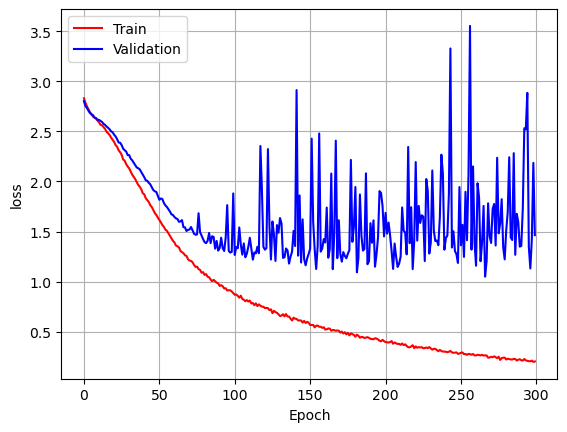

In [18]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

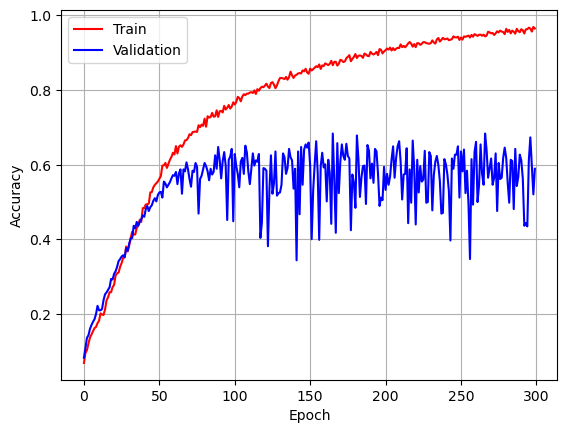

In [19]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

In [8]:

# Training
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"Train Accuracy: {100 * correct / total:.2f}%")

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Train Accuracy: 92.15%
Validation Accuracy: 66.78%
Train Accuracy: 79.63%
Validation Accuracy: 57.53%
Train Accuracy: 90.78%
Validation Accuracy: 65.41%
Train Accuracy: 90.31%
Validation Accuracy: 65.24%
Train Accuracy: 92.62%
Validation Accuracy: 67.81%
Train Accuracy: 94.68%
Validation Accuracy: 69.69%
Train Accuracy: 82.72%
Validation Accuracy: 56.68%
Train Accuracy: 82.12%
Validation Accuracy: 59.42%
Train Accuracy: 93.01%
Validation Accuracy: 70.55%
Train Accuracy: 90.31%
Validation Accuracy: 67.12%
Train Accuracy: 82.80%
Validation Accuracy: 61.82%
Train Accuracy: 68.01%
Validation Accuracy: 46.40%
Train Accuracy: 89.19%
Validation Accuracy: 62.67%
Train Accuracy: 87.39%
Validation Accuracy: 62.67%
Train Accuracy: 87.91%
Validation Accuracy: 61.82%
Train Accuracy: 90.14%
Validation Accuracy: 64.04%
Train Accuracy: 89.62%
Validation Accuracy: 62.84%
Train Accuracy: 85.25%
Validation Accuracy: 63.36%
Train Accuracy: 90.69%
Validation Accuracy: 65.24%
Train Accuracy: 90.74%
Validati